In [47]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import torch
import torch.nn.functional as F
import tqdm
import random

from torch import nn
from einops import rearrange, repeat, pack, unpack
from einops.layers.torch import Rearrange
from torch.utils.data import DataLoader, TensorDataset

from vit_pytorch.vit import Transformer, ViT
from vit_pytorch.mae import MAE

In [21]:
ecg_mat = scipy.io.loadmat('ECGData.mat')

In [22]:
ecg_data = ecg_mat['ECGData'][0][0][0][:20]
print(ecg_data.shape)

(20, 65536)


In [23]:
labels = ecg_mat['ECGData'][0][0][1][:20]
print(labels.shape)

(20, 1)


In [24]:
def split_dataset_indices(N, train_percent, val_percent, test_percent, seed=42):
    # Validate input percentages
    if train_percent + val_percent + test_percent != 100:
        raise ValueError("The sum of the percentages must be 100.")

    random.seed(seed)
    # Generate a list of indices
    indices = list(range(N))
    random.shuffle(indices)

    # Calculate split sizes
    train_size = int((train_percent / 100) * N)
    val_size = int((val_percent / 100) * N)

    # Split indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    return train_indices, val_indices, test_indices

In [25]:
train_indices, val_indices, test_indices = split_dataset_indices(labels.shape[0], 70, 15, 15)

In [26]:
def create_windowed_dataset(data, labels, window_size=1024, stride=None):
    if not stride:
        stride = window_size

    min_val = np.min(data, axis=(0, 1), keepdims=True)
    max_val = np.max(data, axis=(0, 1), keepdims=True)
    data = 2 * ((data - min_val) / (max_val - min_val)) - 1
    
    num_samples, sample_size = data.shape
    num_windows = sample_size // window_size
    
    # Initialize the windowed data and label arrays
    windowed_data = np.empty((num_samples * num_windows, window_size))
    windowed_labels = np.empty((num_samples * num_windows, 1), dtype=labels.dtype)

    for i in range(num_samples):
        for j in range(num_windows):
            start = j * stride
            end = start + window_size
            windowed_data[i * num_windows + j, :] = data[i, start:end]
            windowed_labels[i * num_windows + j, :] = labels[i]

    
    windowed_data = np.stack([windowed_data] * window_size)
    windowed_data = rearrange(windowed_data, 'h n w -> n h w')
    windowed_data = np.stack([windowed_data] * 3)
    windowed_data = rearrange(windowed_data, 'c n h w -> n c h w')

    return torch.tensor(windowed_data, dtype=torch.float32), windowed_labels

In [9]:
ecg_t, labels_t = create_windowed_dataset(ecg_data[train_indices], labels[train_indices], window_size=256)
ecg_v, labels_v = create_windowed_dataset(ecg_data[val_indices], labels[val_indices], window_size=256)

In [10]:
ecg_t.shape

torch.Size([3584, 3, 256, 256])

In [15]:
ecg_v.shape

torch.Size([768, 3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


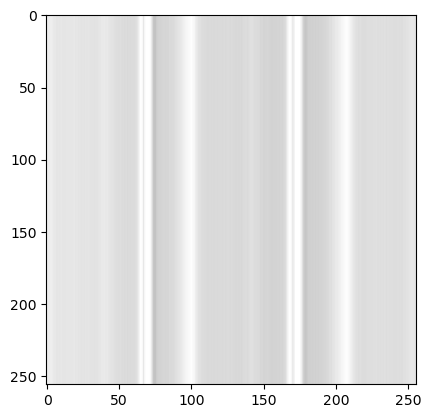

In [35]:
plt.imshow(rearrange(ecg_v[0] + 1, 'c h w -> h w c'))

In [48]:
v = ViT(
    image_size = 256,
    patch_size = 64,
    num_classes = 10,
    dim = 128,
    depth = 12,
    heads = 8,
    mlp_dim = 256,
    channels = 3
)

emb_ex = v.to_patch_embedding(ecg_v)
emb_ex.shape

torch.Size([768, 16, 128])

In [49]:
ecg_v.shape

torch.Size([768, 3, 256, 256])

In [55]:
ecg_t[:1].shape

torch.Size([1, 3, 256, 256])

In [58]:
import torch
from torch import nn
import torch.nn.functional as F
from einops import repeat

from vit_pytorch.vit import Transformer

class MAE(nn.Module):
    def __init__(
        self,
        *,
        encoder,
        decoder_dim,
        masking_ratio = 0.75,
        decoder_depth = 1,
        decoder_heads = 8,
        decoder_dim_head = 64
    ):
        super().__init__()
        assert masking_ratio > 0 and masking_ratio < 1, 'masking ratio must be kept between 0 and 1'
        self.masking_ratio = masking_ratio

        # extract some hyperparameters and functions from encoder (vision transformer to be trained)

        self.encoder = encoder
        num_patches, encoder_dim = encoder.pos_embedding.shape[-2:]

        self.to_patch = encoder.to_patch_embedding[0]
        self.patch_to_emb = nn.Sequential(*encoder.to_patch_embedding[1:])

        pixel_values_per_patch = encoder.to_patch_embedding[2].weight.shape[-1]

        # decoder parameters
        self.decoder_dim = decoder_dim
        self.enc_to_dec = nn.Linear(encoder_dim, decoder_dim) if encoder_dim != decoder_dim else nn.Identity()
        self.mask_token = nn.Parameter(torch.randn(decoder_dim))
        self.decoder = Transformer(dim = decoder_dim, depth = decoder_depth, heads = decoder_heads, dim_head = decoder_dim_head, mlp_dim = decoder_dim * 4)
        self.decoder_pos_emb = nn.Embedding(num_patches, decoder_dim)
        self.to_pixels = nn.Linear(decoder_dim, pixel_values_per_patch)

    def forward(self, img):
        device = img.device

        # get patches

        patches = self.to_patch(img)
        batch, num_patches, *_ = patches.shape

        # patch to encoder tokens and add positions

        tokens = self.patch_to_emb(patches)
        if self.encoder.pool == "cls":
            tokens += self.encoder.pos_embedding[:, 1:(num_patches + 1)]
        elif self.encoder.pool == "mean":
            tokens += self.encoder.pos_embedding.to(device, dtype=tokens.dtype) 

        # calculate of patches needed to be masked, and get random indices, dividing it up for mask vs unmasked

        num_masked = int(self.masking_ratio * num_patches)
        rand_indices = torch.rand(batch, num_patches, device = device).argsort(dim = -1)
        masked_indices, unmasked_indices = rand_indices[:, :num_masked], rand_indices[:, num_masked:]

        # get the unmasked tokens to be encoded

        batch_range = torch.arange(batch, device = device)[:, None]
        tokens = tokens[batch_range, unmasked_indices]

        # get the patches to be masked for the final reconstruction loss

        masked_patches = patches[batch_range, masked_indices]

        # attend with vision transformer

        encoded_tokens = self.encoder.transformer(tokens)

        # project encoder to decoder dimensions, if they are not equal - the paper says you can get away with a smaller dimension for decoder

        decoder_tokens = self.enc_to_dec(encoded_tokens)

        # reapply decoder position embedding to unmasked tokens

        unmasked_decoder_tokens = decoder_tokens + self.decoder_pos_emb(unmasked_indices)

        # repeat mask tokens for number of masked, and add the positions using the masked indices derived above

        mask_tokens = repeat(self.mask_token, 'd -> b n d', b = batch, n = num_masked)
        mask_tokens = mask_tokens + self.decoder_pos_emb(masked_indices)

        # concat the masked tokens to the decoder tokens and attend with decoder
        
        decoder_tokens = torch.zeros(batch, num_patches, self.decoder_dim, device=device)
        decoder_tokens[batch_range, unmasked_indices] = unmasked_decoder_tokens
        decoder_tokens[batch_range, masked_indices] = mask_tokens
        decoded_tokens = self.decoder(decoder_tokens)

        # splice out the mask tokens and project to pixel values

        mask_tokens = decoded_tokens[batch_range, masked_indices]
        pred_pixel_values = self.to_pixels(mask_tokens)

        # calculate reconstruction loss

        recon_loss = F.mse_loss(pred_pixel_values, masked_patches)
        return recon_loss, patches.detach().numpy(), masked_indices.detach().numpy(), pred_pixel_values.detach().numpy()


In [65]:
mae = MAE(
    encoder = v,
    masking_ratio = 0.25,   # the paper recommended 75% masked patches
    decoder_dim = 128,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

loss, patches, masked_indices, pred_pixel_values = mae(ecg_t[:1])
print(loss)

tensor(0.3749, grad_fn=<MseLossBackward0>)


In [60]:
print('masked_indices:')
print(masked_indices.shape)

print('patches:')
print(patches.shape)

print('pred_pixel_values:')
print(pred_pixel_values.shape)

masked_indices:
(1, 4)
patches:
(1, 16, 12288)
pred_pixel_values:
(1, 4, 12288)


In [71]:
# Function to create batches - returns a DataLoader
def create_batches(data, batch_size):
    tensor_data = torch.Tensor(data)
    dataset = TensorDataset(tensor_data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Function to determine the tqdm environment
def get_tqdm():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return tqdm_notebook.tqdm
        else:
            return tqdm.tqdm
    except NameError:
        return tqdm.tqdm

# Training loop
def train_model(train_data, val_data, batch_size, num_epochs, model, optimizer):
    # Use the appropriate tqdm version
    tqdm_bar = get_tqdm()

    # Create batches
    dataloader = create_batches(train_data, batch_size)

    for epoch in range(num_epochs):
        total_loss, num_batches = 0, 0
        with tqdm_bar(total=len(dataloader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
            for data_batch in dataloader:
                loss, _, _, _ = mae(data_batch[0])
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                num_batches += 1

                average_loss = total_loss / num_batches
                pbar.set_postfix(avg_loss=average_loss)
                pbar.update()
            with torch.no_grad():
                loss_v, patches_v, masked_indices_v, pred_pixel_values_v = mae(val_data)
                #plot_example(patches_v, masked_indices_v, pred_pixel_values_v, 0)
                pbar.set_postfix(train_loss=average_loss, val_loss=loss_v.detach().numpy())

In [72]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(mae.parameters(), lr=learning_rate)
train_model(ecg_t, ecg_v, batch_size=32, num_epochs=5, model=mae, optimizer=optimizer)

Epoch 5/5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [05:09<00:00,  2.76s/it, train_loss=0.0248, val_loss=0.10288219]


In [73]:
with torch.no_grad():
    loss_t, patches_t, masked_indices_t, pred_pixel_values_t = mae(ecg_t[:100])
    loss_v, patches_v, masked_indices_v, pred_pixel_values_v = mae(ecg_v)

In [ ]:
# Example for one sequence (index 0)

def plot_example(patches, masked_indices, pred_pixel_values, sequence_index):
    original_sequence = patches[sequence_index].reshape(-1)  # Reshape to 1D
    
    masked_patches = masked_indices[sequence_index]
    reconstructed_patches = pred_pixel_values[sequence_index]
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(original_sequence, label='Original Sequence', color='blue', linewidth=2)

    seq_len = patches.shape[1] * patches.shape[2]
    patch_size = patches.shape[2]
    
    # Subtle patch boundaries
    for i in range(0, seq_len, patch_size):
        plt.axvline(x=i, color='lightgray', linestyle='--', alpha=0.5)
    
    # Subtle background for masked areas
    for idx in masked_patches:
        plt.axvspan(idx * patch_size, (idx + 1) * patch_size, color='lightgray', alpha=0.2)
    
    # Show reconstructed patches (assuming they're in the same order as masked_indices)
    for i, idx in enumerate(masked_patches):
        reconstructed_section = reconstructed_patches[i].reshape(-1)
        plt.plot(range(idx * patch_size, (idx + 1) * patch_size), reconstructed_section, color='lightblue', linewidth=2.5, alpha=0.4)
    
    plt.legend()
    plt.title('Time-Series Data with MAE Reconstruction')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

In [ ]:
plot_example(patches_t, masked_indices_t, pred_pixel_values_t, 0)

In [90]:
patches_t[0].shape

(16, 12288)

In [100]:
patches_rearranged = rearrange(patches_t[0], 'num_patches (ph pw c) -> num_patches c ph pw', c=3, ph=64, pw=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


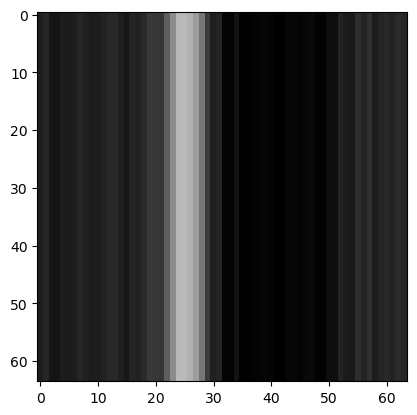

In [104]:
plt.imshow(rearrange(patches_rearranged[2], 'c h w -> h w c'))

In [111]:
pred_pixels_rearranged = rearrange(pred_pixel_values_t[0][2], '(ph pw c) -> c ph pw', c=3, ph=64, pw=64)
pred_pixels_rearranged.shape

(3, 64, 64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


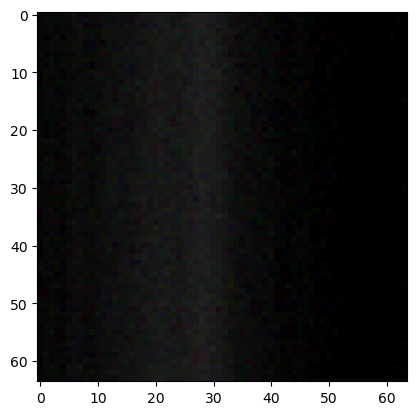

In [112]:
plt.imshow(rearrange(pred_pixels_rearranged, 'c h w -> h w c'))

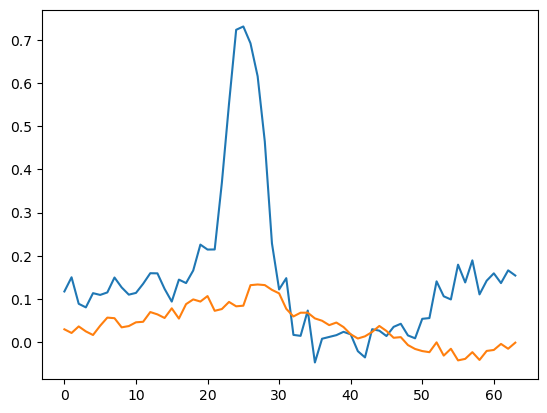

In [115]:
plt.plot(patches_rearranged[2][0, 0, :])
plt.plot(pred_pixels_rearranged[0, 0, :])